In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import pickle

from spike_and_slab_ser import SpikeSlabSER

### Simulated Example

Here we simulate summary statistics (zscores) on ~2000 SNPs across 10 tissues.

There are 4 causal SNPs in the sumation active it tissues[0-1], [2-5], [4-8], [0-8] respectively. The final tissue has no causal SNPs active in it.

To train the model we use a forward selection scheme on the variational parameters. That is, we first train the model as if there were only one component with various initializations. We select the best model in terms of the evidence lower bound. We then train the model as through there were two components with various initializations, and again select the model with the best ELBO. We proceed until we are learning the full model with K models.

This approach is always increasing in the elbo. In the lth step we are simply performing coordinate ascent on the variaional parameters except that the last $(K-l)$ components are  fixed at a setting where they are irrelevant/inactive. While this is considerably slower than training everything at once, we hope it avoids a lot of poor local optima. Specifically, we hope this avoids the scenario where two components capture the same effect. At a forward step, the elbo will prefer a model that describes new areas of the data to an model that captures the same effect.

We also think this is necessary since the terminal state of the component is extremely sensitive to initialization of the weights. The simple solution is that for each initialization we assign a weight of 1 to one tissue and 0 to the others-- this initialization is destined to find a component that includes the active tissue. Do this across all tissues and select the best initialization.

In [4]:
Sigma, causal_snps, tissue_membership, causal = pickle.load(open('../simulation_scripts/T10_simulation', 'rb'))
T, N = causal.shape

effectsize = 5  # zscore @ causal snps

Sigma_reg = (Sigma + np.eye(N)*1e-6) / (1+1e-6)
chol = np.linalg.cholesky(Sigma_reg)

# simulate data according to MVN distribution of marignal test statistics
Y = (effectsize * Sigma @ causal.T + chol @ np.random.normal(size=causal.T.shape)).T
X = Sigma_reg

### Setting up the model
There are three parameters you need to specify.
1. `K` is the max number of components.
2. `prior_activity` is an array of length `K` with the prior probability that a tissues is active in each component. 
3. `prior_variance` is the prior variance on the entries of the weight matrix. This parameters can have a large impact on the performance of the algorithm. The variation approximmation $q(\{w_{tk}, s_{tk}\})$ is a mixture of two gaussians-- an approximate posterior to $p(w_{tk} | s_{tk} = 1)$ and $p(w_{tk} | s_{tk} = 0) = p(w_{tk})$. It turns out that the variance of the first distribution is determined by `prior_variance`-- small setting will result in harder assignments

There are two pieces of data you need to provide to the model 
1. `X` is the $N \times N$ LD matrix
2. `Y` is a $T \times N$ matrix of z-scores for each SNP in T tissues

You can also provide labels $\text{snp_ids}$ and $\text{tissue_ids}$ that will make the output of the model easier to read

There is no reason the model can't support NAN entries in $Y$ but that needs to implemented

In [7]:
K = 8
prior_activity = np.exp(-1*np.linspace(2, 2, K))
prior_variance = 10.0

model = SpikeSlabSER(
    X=X, Y=Y, K=K,
    snp_ids=np.arange(N), tissue_ids=np.arange(T),
    prior_activity=prior_activity,
    prior_variance=prior_variance
)

In [8]:
%%time
model.forward_fit(early_stop=True)

Forward fit, learning 1 components
Forward fit, learning 2 components
Forward fit, learning 3 components
Forward fit, learning 4 components
Forward fit, learning 5 components
learned inactive cluster, finalizing parameters
CPU times: user 1min 56s, sys: 218 ms, total: 1min 56s
Wall time: 29.1 s


### Plots

Example call of different plotting functions

`plot_component(thresh=0.1)` plots the probability of using a component, weights of each component per tissue, and the posterior categorical distributions of each active component, components which have $p(\text{tissue t active in component k}) > \text{thresh}$ for some tissue

`plot_predictions()` in the first row superimposes the observed z scores (black crosses) and expected value under the trained model (red circles), in the second row plots predictions against observed z scores

`plot_manhattan(component, thresh=0.0)` makes manhattan plots for a component, colored by r^2 with the top snp in that component. `thresh` is a minimum probability to include a tissue in the plot. Tissues are plotted in decreasing order of probability of using `component`

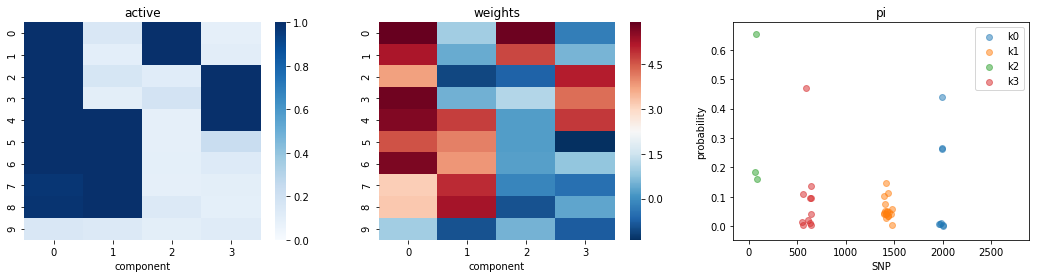

In [9]:
model.plot_components()

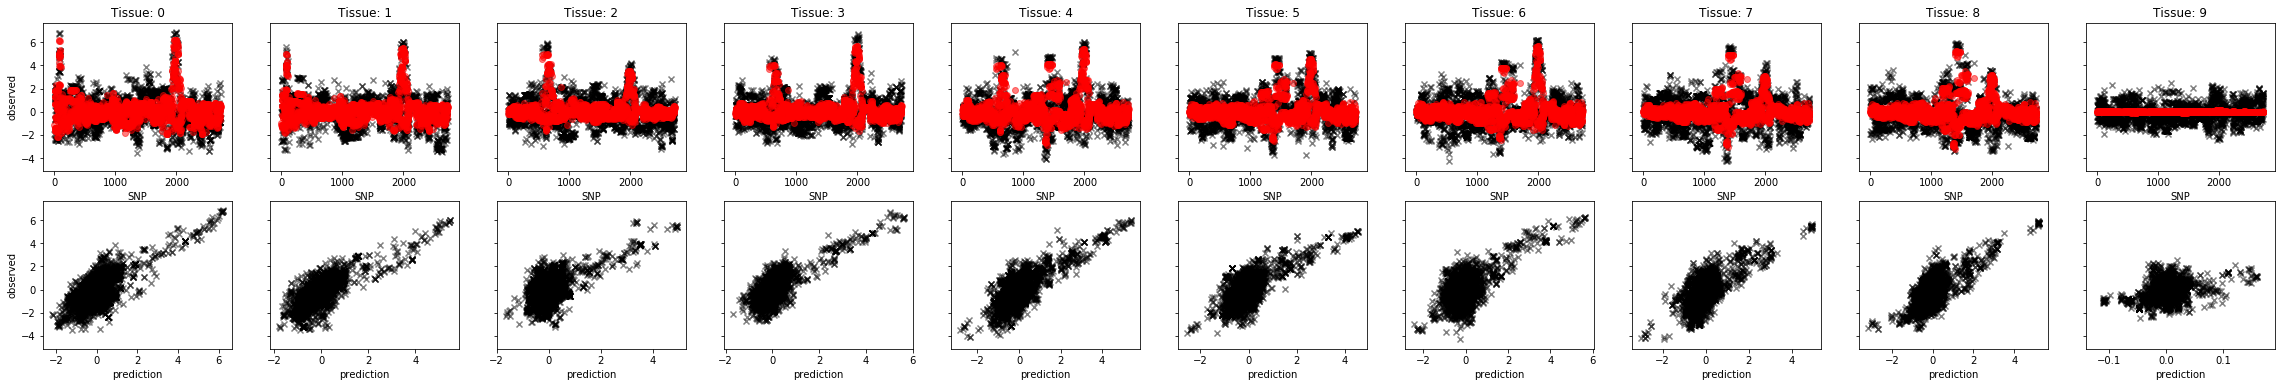

In [10]:
model.plot_predictions()

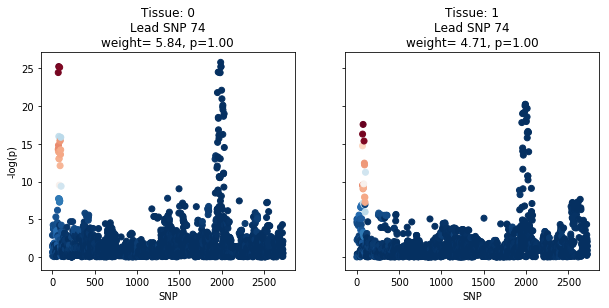

In [11]:
model.plot_manhattan(component=2, thresh=0.5)

### Looking at inducing points

Each component squeezes the data through one SNP. With a linear kernel we can think of this as a linear regression over SNPs with a single feature-- the correlation with some other SNP $z$. We put a categorical prior on $z$. Looking at the posterior shows us likely causal SNPs for the signal captured by that component

`get_top_snp_per_component()` returns the top SNP per component and the probability assigned to that snp

`get_confidence_sets(alpha=0.9, thresh=0.1)` returns, for each component, the top weighted snps so that $\sum p_i > \alpha$, 'thresh' filters out components with maximum assignment probability $ < \text{thresh}$

In [12]:
np.set_printoptions(precision=3, suppress=True)
top_snps, top_snp_probabilities = model.get_top_snp_per_component()
print('True causal snps {}\nTop SNP per component {}\nProbability of top SNP: {}'.format(causal_snps, top_snps, top_snp_probabilities))

True causal snps [  74  588 1413 1987]
Top SNP per component [1987 1413   74  588 1962 1962 1962 1962]
Probability of top SNP: [0.441 0.146 0.653 0.47  0.    0.    0.    0.   ]


In [13]:
cs = model.get_confidence_sets(0.9)
print('\n'.join(['component {}: {}'.format(key, cs[key]) for key in cs.keys()]))

component 0: [1987 1990 1991]
component 1: [1413 1437 1392 1406 1476 1402 1424 1443 1429 1398 1415 1414 1470 1389]
component 2: [74 68 85]
component 3: [588 642 555 635 641]


### Colocalization

`get_component_colocalization(component)` returns the probability under the model that two tissues both use `component`

`get_global_colocalization` returns the probability that pairs of tissues share at least one component in common

In [14]:
model.get_component_colocalization(0)

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.999999,0.997803,1.000000,1.000000,0.999963,1.000000,0.975897,0.982432,0.153094
1,0.999999,0.999998,0.997802,0.999999,0.999999,0.999962,0.999999,0.975897,0.982431,0.153094
2,0.997803,0.997802,0.995610,0.997803,0.997803,0.997766,0.997803,0.973753,0.980273,0.152758
3,1.000000,0.999999,0.997803,1.000000,1.000000,0.999963,1.000000,0.975897,0.982432,0.153094
4,1.000000,0.999999,0.997803,1.000000,1.000000,0.999963,1.000000,0.975897,0.982432,0.153094
5,0.999963,0.999962,0.997766,0.999963,0.999963,0.999926,0.999963,0.975861,0.982395,0.153089
6,1.000000,0.999999,0.997803,1.000000,1.000000,0.999963,1.000000,0.975897,0.982432,0.153094
7,0.975897,0.975897,0.973753,0.975897,0.975897,0.975861,0.975897,0.952376,0.958753,0.149404
8,0.982432,0.982431,0.980273,0.982432,0.982432,0.982395,0.982432,0.958753,0.965172,0.150405
9,0.153094,0.153094,0.152758,0.153094,0.153094,0.153089,0.153094,0.149404,0.150405,0.023438


In [15]:
model.get_global_colocalzation()

,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,0.998341,1.000000,1.000000,0.999973,1.000000,0.982258,0.987758,0.290838
1,1.000000,1.000000,0.998351,0.999999,0.999999,0.999971,0.999999,0.981124,0.986975,0.286576
2,0.998341,0.998351,1.000000,1.000000,1.000000,0.998638,0.998471,0.981165,0.985824,0.306332
3,1.000000,0.999999,1.000000,1.000000,1.000000,0.999976,1.000000,0.981579,0.986602,0.305801
4,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.387728
5,0.999973,0.999971,0.998638,0.999976,1.000000,1.000000,1.000000,0.999991,0.999993,0.322300
6,1.000000,0.999999,0.998471,1.000000,1.000000,1.000000,1.000000,0.999971,0.999979,0.312877
7,0.982258,0.981124,0.981165,0.981579,1.000000,0.999991,0.999971,1.000000,1.000000,0.307496
8,0.987758,0.986975,0.985824,0.986602,1.000000,0.999993,0.999979,1.000000,1.000000,0.311542
9,0.290838,0.286576,0.306332,0.305801,0.387728,0.322300,0.312877,0.307496,0.311542,0.097732


### Real eQTL example

Now we show a quick run through a real eQTL exaple

In [16]:
def get_inputs(zscore_path, ld_path, gene):
    """
    small helper function to read in data
    we also regulize our estimate of X by adding a small positive to diagonal and renormalizing
    this shouldnt do much to change the shape of the data distribution, just make it full rank
    """
    X = pd.read_csv(ld_path + gene, index_col=0)
    zscores = pd.read_csv(zscore_path + gene + '.zscore_matrix.txt', '\t', index_col=0)

    nan_snps = np.all(np.isnan(X.values), axis=1)
    X = X.iloc[~nan_snps].iloc[:, ~nan_snps]

    active_snps = np.isin(X.index, zscores.index)
    X = X.iloc[active_snps].iloc[:, active_snps]

    active_snps = np.isin(zscores.index, X.index)
    Y = zscores.iloc[active_snps]
    Y = Y.iloc[:, ~np.any(np.isnan(Y.values), 0)]
    

    tissues = Y.columns.values
    snp_ids = Y.index.values
    pos = np.array([int(snp_id.split('_')[1]) for snp_id in snp_ids])

    Y = Y.T.values
    X = X.values
    X = (X + np.eye(X.shape[0])*1e-6) / (1+1e-6)
    
    return X, Y, tissues, snp_ids

In [17]:
gene = 'ENSG00000073464.11'
#gene = 'ENSG00000141644.17'
#gene = 'ENSG00000164904.17'

In [18]:
ld_path = '../marios_correlation_matrices/'
zscoore_path = '../data/zscore_genes_for_Karl/'

X, Y, tissues, snp_ids = get_inputs(zscoore_path, ld_path, gene)
T, N = Y.shape

In [19]:
K = 10
prior_activity = np.exp(-1*np.linspace(3, 3, K))
model = SpikeSlabSER(X, Y, K, snp_ids, tissues, prior_activity, 10.0)

model.forward_fit()

Forward fit, learning 1 components
Forward fit, learning 2 components
Forward fit, learning 3 components
Forward fit, learning 4 components
Forward fit, learning 5 components
Forward fit, learning 6 components
Forward fit, learning 7 components
Forward fit, learning 8 components
Forward fit, learning 9 components
Forward fit, learning 10 components


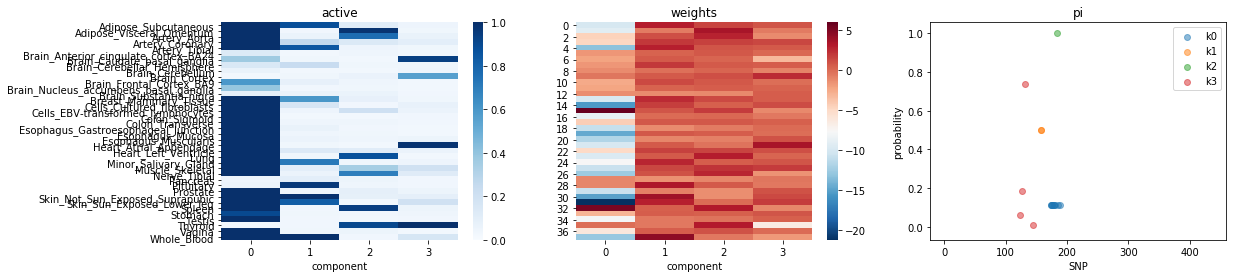

In [20]:
model.plot_components()

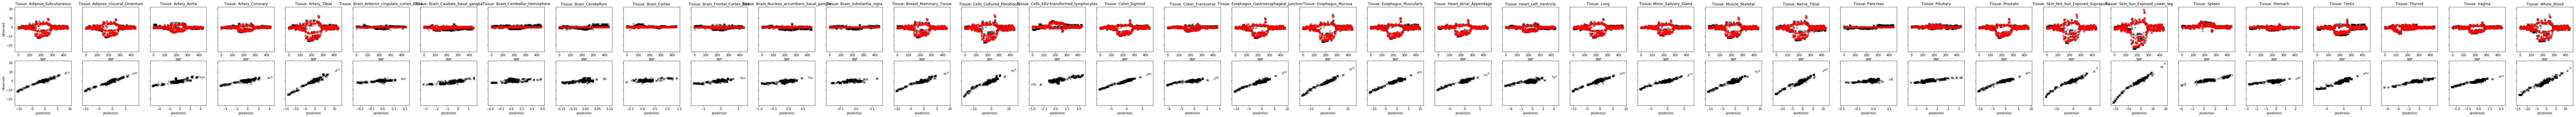

In [21]:
model.plot_predictions()

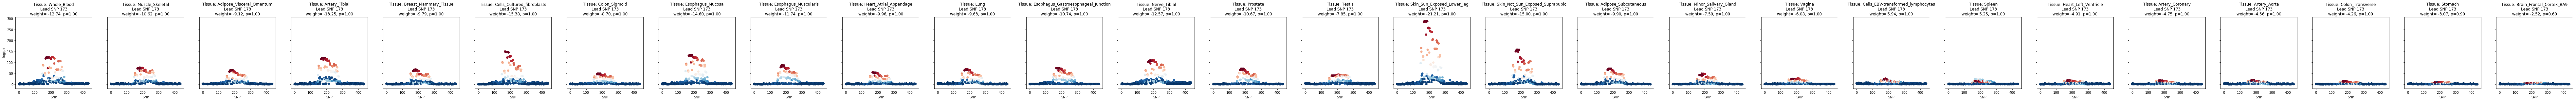

In [22]:
model.plot_manhattan(component=0, thresh=0.5)

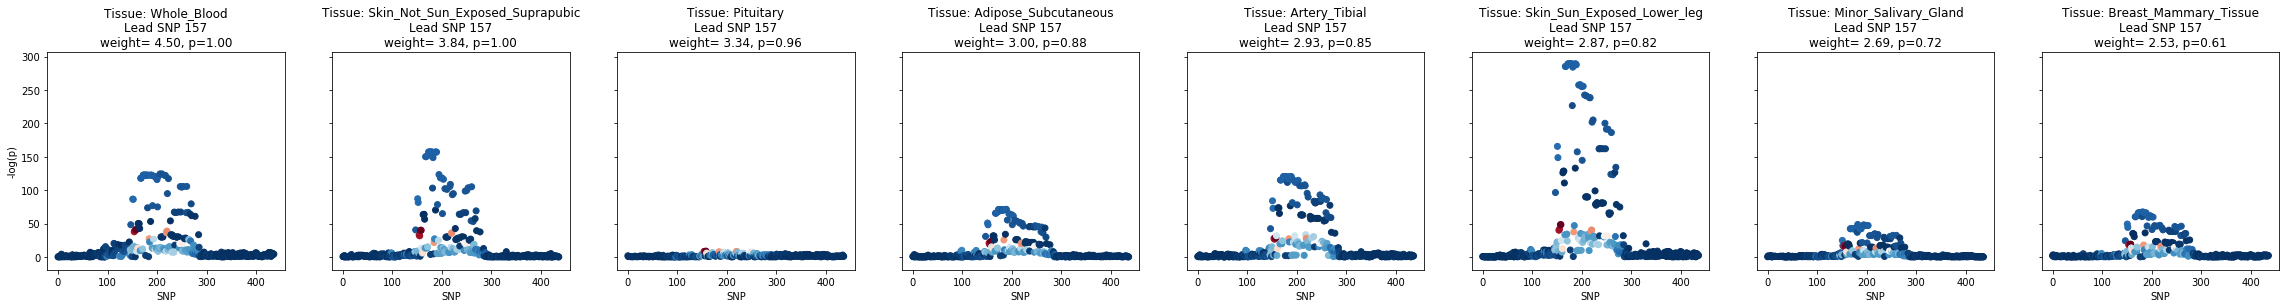

In [23]:
model.plot_manhattan(component=1, thresh=0.5)

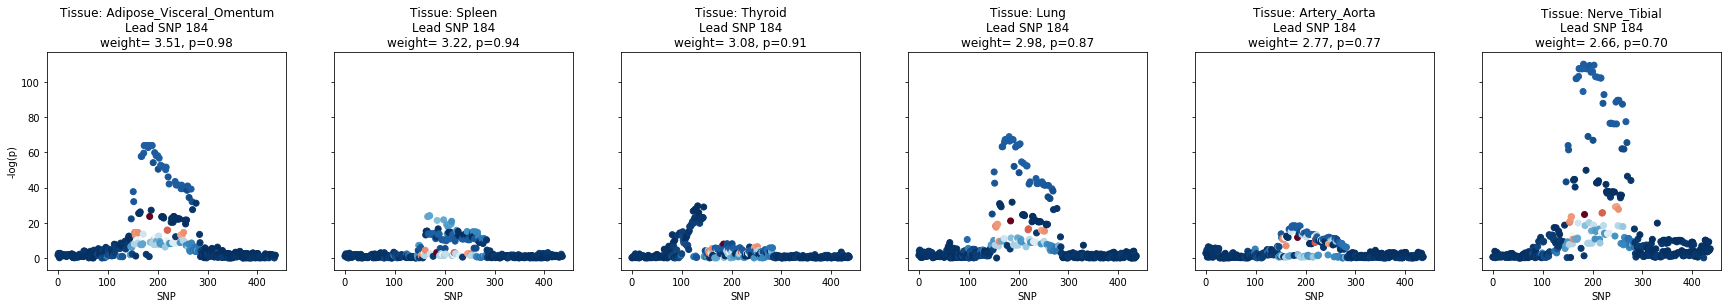

In [24]:
model.plot_manhattan(component=2, thresh=0.5)

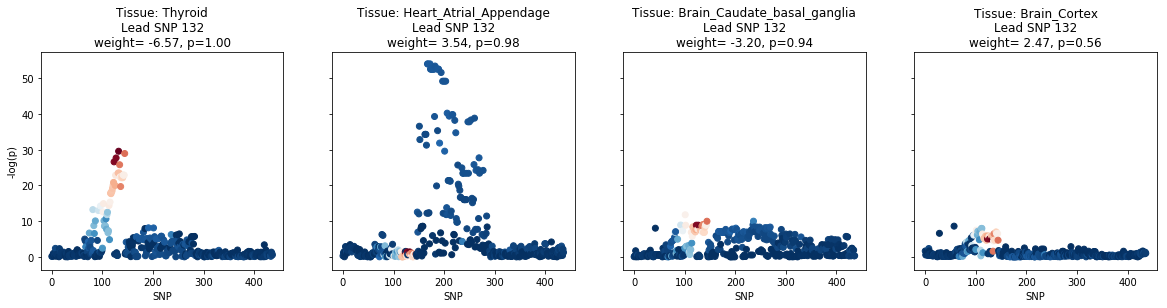

In [25]:
model.plot_manhattan(component=3, thresh=0.5)

In [29]:
model.get_component_colocalization(0)

,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,Brain_Cerebellum,Brain_Cortex,...,Pituitary,Prostate,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,Spleen,Stomach,Testis,Thyroid,Vagina,Whole_Blood
Adipose_Subcutaneous,1.000000,1.000000,0.999883,0.999960,1.000000,0.132849,0.373434,0.151054,0.073148,0.034900,...,0.058682,1.000000,1.000000,1.000000,0.999998,0.903697,1.000000,0.032327,1.000000,1.000000
Adipose_Visceral_Omentum,1.000000,1.000000,0.999883,0.999960,1.000000,0.132849,0.373434,0.151054,0.073148,0.034900,...,0.058682,1.000000,1.000000,1.000000,0.999998,0.903697,1.000000,0.032327,1.000000,1.000000
Artery_Aorta,0.999883,0.999883,0.999765,0.999843,0.999883,0.132833,0.373390,0.151037,0.073139,0.034896,...,0.058675,0.999883,0.999883,0.999883,0.999881,0.903591,0.999883,0.032324,0.999883,0.999883
Artery_Coronary,0.999960,0.999960,0.999843,0.999920,0.999960,0.132843,0.373419,0.151048,0.073145,0.034899,...,0.058680,0.999960,0.999960,0.999960,0.999958,0.903661,0.999960,0.032326,0.999960,0.999960
Artery_Tibial,1.000000,1.000000,0.999883,0.999960,1.000000,0.132849,0.373434,0.151054,0.073148,0.034900,...,0.058682,1.000000,1.000000,1.000000,0.999998,0.903697,1.000000,0.032327,1.000000,1.000000
Brain_Anterior_cingulate_cortex_BA24,0.132849,0.132849,0.132833,0.132843,0.132849,0.017649,0.049610,0.020067,0.009718,0.004636,...,0.007796,0.132849,0.132849,0.132849,0.132848,0.120055,0.132849,0.004295,0.132849,0.132849
Brain_Caudate_basal_ganglia,0.373434,0.373434,0.373390,0.373419,0.373434,0.049610,0.139453,0.056409,0.027316,0.013033,...,0.021914,0.373434,0.373434,0.373434,0.373433,0.337471,0.373434,0.012072,0.373434,0.373434
Brain_Cerebellar_Hemisphere,0.151054,0.151054,0.151037,0.151048,0.151054,0.020067,0.056409,0.022817,0.011049,0.005272,...,0.008864,0.151054,0.151054,0.151054,0.151054,0.136507,0.151054,0.004883,0.151054,0.151054
Brain_Cerebellum,0.073148,0.073148,0.073139,0.073145,0.073148,0.009718,0.027316,0.011049,0.005351,0.002553,...,0.004292,0.073148,0.073148,0.073148,0.073147,0.066103,0.073148,0.002365,0.073148,0.073148
Brain_Cortex,0.034900,0.034900,0.034896,0.034899,0.034900,0.004636,0.013033,0.005272,0.002553,0.001218,...,0.002048,0.034900,0.034900,0.034900,0.034900,0.031539,0.034900,0.001128,0.034900,0.034900


In [30]:
model.get_global_colocalzation()

,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,Brain_Cerebellum,Brain_Cortex,...,Pituitary,Prostate,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,Spleen,Stomach,Testis,Thyroid,Vagina,Whole_Blood
Adipose_Subcutaneous,1.000000,1.000000,0.999900,0.999970,1.000000,0.171673,0.433140,0.339930,0.112444,0.110620,...,0.858148,1.000000,1.000000,1.000000,0.999998,0.908395,1.000000,0.208419,1.000000,1.000000
Adipose_Visceral_Omentum,1.000000,1.000000,0.999971,0.999966,1.000000,0.180319,0.421704,0.199521,0.111972,0.126126,...,0.139284,1.000000,1.000000,1.000000,1.000000,0.908156,1.000000,0.899344,1.000000,1.000000
Artery_Aorta,0.999900,0.999971,0.999904,0.999864,0.999894,0.173062,0.436494,0.197742,0.107478,0.129978,...,0.152301,0.999892,0.999899,0.999894,0.999967,0.907514,0.999887,0.728388,0.999889,0.999895
Artery_Coronary,0.999970,0.999966,0.999864,0.999928,0.999970,0.154699,0.444142,0.217151,0.095847,0.112470,...,0.305294,0.999962,0.999971,0.999970,0.999965,0.906251,0.999961,0.251848,0.999961,0.999971
Artery_Tibial,1.000000,1.000000,0.999894,0.999970,1.000000,0.167859,0.425950,0.332172,0.108998,0.100876,...,0.832926,1.000000,1.000000,1.000000,0.999998,0.907998,1.000000,0.152114,1.000000,1.000000
Brain_Anterior_cingulate_cortex_BA24,0.171673,0.180319,0.173062,0.154699,0.167859,0.028150,0.088247,0.038014,0.020216,0.033844,...,0.050245,0.145449,0.176220,0.172106,0.179150,0.129954,0.141971,0.084688,0.142585,0.174562
Brain_Caudate_basal_ganglia,0.433140,0.421704,0.436494,0.444142,0.425950,0.088247,0.899980,0.109579,0.082562,0.539784,...,0.101574,0.414292,0.457947,0.514613,0.430477,0.374667,0.401822,0.942405,0.399139,0.497868
Brain_Cerebellar_Hemisphere,0.339930,0.199521,0.197742,0.217151,0.332172,0.038014,0.109579,0.088828,0.028872,0.046875,...,0.245423,0.171725,0.364468,0.331604,0.198230,0.153767,0.167018,0.094475,0.167841,0.364371
Brain_Cerebellum,0.112444,0.111972,0.107478,0.095847,0.108998,0.020216,0.082562,0.028872,0.016318,0.040799,...,0.044982,0.086334,0.118009,0.116387,0.111486,0.076918,0.083075,0.087975,0.083361,0.118039
Brain_Cortex,0.110620,0.126126,0.129978,0.112470,0.100876,0.033844,0.539784,0.046875,0.040799,0.326009,...,0.069844,0.079762,0.134553,0.182040,0.132191,0.068674,0.065400,0.592701,0.063863,0.168551
